
## Управление рисками в финансовых учреждениях, 2019

Для выполнения работы необходимо поместить в дирикторию './data' .csv файлы котировок с сайта финам (логика обработки данных учитывает все поля, которые стандартно предлагаются источником). 

Функции paths_define() и one_ticker_data() предназначены для загрузки данных в numpy.array & pd.DataFrame объекты. 

Реализован класс DataCounter для расчета всех требуемых показателей, результаты приведены в таблице ниже (в месте составления применения результатов кода). Код построен так, что можно посчитать для абсолютно любого количества файлов требуемые показатели (поскольку нужно только для 2 бумаг, то этот цикл не реализован.. при желании - 3 строчки кода). Также построены графики и приведены тесты на нормальность, показывающие возможность применения параметрического подхода, основанного на предположении о логнормальности доходностей. 

Окно выбрано в 252 дня торговых дня.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import os 
from scipy.stats import norm 
from scipy.ndimage.interpolation import shift 
from collections import deque
from scipy.stats import shapiro, kstest

pd.options.display.max_rows = 100 

In [2]:
def paths_define(root='', dir_data='data'):
    path = os.path.abspath(root)
    files_path = os.path.join(path, dir_data)
    files_list = os.listdir(files_path)
    drop_list = []
    for j in range(len(files_list)):
        if files_list[j][-4:] != '.csv':
            drop_list.append(files_list[j])
    for j in range(len(drop_list)): 
        files_list.remove(drop_list[j])
        
    files_paths = list(map(lambda x: os.path.join(files_path, x), files_list))
    
    return files_paths

In [3]:
def one_ticker_data(path, sep=',', skiprows=1):
    df = pd.read_csv(path, sep=sep, skiprows=skiprows, 
                     names=['Ticker', 'Per', 'Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Vol'])
    df = pd.DataFrame(df[['Ticker', 'Date', 'Close']])
    df = df.sort_values(by=['Ticker', 'Date'], ascending=True)
    
    return df

In [4]:
class DataCounter:
    
    
    def __init__(self, path): 
        self._data = one_ticker_data(path)
        
        self.ticker = self._data['Ticker'].unique()[0]
        self.date = np.array(self._data['Date'])
        self.price = np.array(self._data['Close'])
        
        self.returns = None
        self.logreturns = None
        self.risk_returns = None 
        self.risk_logreturns = None 
        
        self.historical_var = None 
        self.historical_ear = None 
        self.historical_rorac = None 
        
        self.var = None 
        self.ear = None 
        self.rorac = None 
        
        self.__manip = 1
        self.__manvar = 1 
        self.__manear = 1 
        self.__manrorac = 1 
        
        self.__var = 1 
        self.__ear = 1 
        self.__rorac = 1
        
        
    def solve_returns(self): 
        self.returns = np.array([np.nan] + list((self.price[1:] - shift(self.price, 1)[1:]) / shift(self.price, 1)[1:]))
        self.logreturns = np.array([np.nan] + list(np.log(self.price[1:] / shift(self.price, 1)[1:])))
        self.risk_returns = - self.returns 
        self.risk_logreturns = -self.logreturns
        self.__manip = 0
    
    
    def var_hist(self, window=252, perc=.01): 
        if self.__manip: 
            self.solve_returns()
        self.historical_var = [np.nan] * len(self.returns)
        
        if self.__manvar:
            calc_deque = deque(maxlen=window)
            for j in range(len(self.risk_returns)): 
                if self.risk_returns[j] != np.nan: 
                    calc_deque.append(self.risk_returns[j])
                else:
                    continue
                if len(calc_deque) == window: 
                    self.historical_var[j] = -min(pd.Series(calc_deque).quantile(perc), 0)
            self.__manvar = 0
        
        return self.historical_var
    
    
    def ear_hist(self, window=252, perc=0.5): 
        if self.__manip:
            self.solve_returns()
        self.historical_ear = [np.nan] * len(self.logreturns)
        
        if self.__manear:
            calc_deque = deque(maxlen=window)
            for j in range(len(self.logreturns)):
                if self.logreturns[j] != np.nan: 
                    calc_deque.append(self.logreturns[j])
                else:
                    continue
                if len(calc_deque) == window:
                    self.historical_ear[j] = -pd.Series(calc_deque).quantile(perc)
            self.__manear = 0
        
        return self.historical_ear
    
    
    def rorac_hist(self, window=252):
        if self.__manip:
            self.solve_returns()
        if self.__manvar:
            self.var_hist()
        if self.__manear: 
            self.ear_hist()
        if self.__manrorac: 
            self.historical_rorac = (self.logreturns - self.historical_ear) / self.historical_var
            self.__manrorac = 0
        
        return self.historical_rorac
    
    
    def var_param(self, window=252, perc=0.01):
        if self.__manip:
            self.solve_returns()
        self.var = [np.nan] * len(self.logreturns)
        
        if self.__var:
            calc_deque = deque(maxlen=window)
            for j in range(len(self.logreturns)):
                if self.logreturns[j] != np.nan: 
                    calc_deque.append(self.logreturns[j])
                else:
                    continue
                if len(calc_deque) == window: 
                    self.var[j] = -min(norm.ppf(perc, np.mean(pd.Series(calc_deque)), np.std(pd.Series(calc_deque))), 0)
            self.__var = 0
        self.var = np.array(self.var)
        
        return self.var
    
    
    def ear_param(self, window=252, perc=0.5):
        if self.__manip: 
            self.solve_returns()
        self.ear = [np.nan] * len(self.logreturns)
        
        if self.__ear: 
            calc_deque = deque(maxlen=window)
            for j in range(len(self.logreturns)):
                if self.logreturns[j] != np.nan: 
                    calc_deque.append(self.logreturns[j])
                else: 
                    continue
                if len(calc_deque) == window: 
                    self.ear[j] = -norm.ppf(perc, np.mean(pd.Series(calc_deque)), np.std(pd.Series(calc_deque)))
            self.__var = 0
        self.ear = np.array(self.ear)
        
        return self.ear
    
    
    def rorac_param(self):
        if self.__manip:
            self.solve_returns()
        if self.__var:
            self.var_param()
        if self.__ear:
            self.ear_param()
        self.rorac = (self.logreturns - self.ear) / self.var
        self.rorac = np.array(self.rorac)
        
        return self.rorac

    
    def solve(self): 
        if self.__manip:
            self.solve_returns()
        if self.__manvar:
            self.var_hist()
        if self.__manear:
            self.ear_hist()
        if self.__manrorac:
            self.rorac_hist()
        
        if self.__var:
            self.var_param()
        if self.__ear:
            self.ear_param()
        if self.__rorac:
            self.rorac_param()
            
        array = [self.date, self.historical_var, self.historical_ear, self.historical_rorac,\
                 self.var, self.ear, self.rorac]
        
        self.result = pd.DataFrame(array).transpose()
        self.result.columns = ['Date', 'Hist VaR', 'Hist EaR', 'Hist RORAC', 'Param VaR',
                               'Param EaR', 'Param RORAC']
        self.result = self.result.dropna()
        self.result.Date = self.result.Date.astype(int)
        
        return self.result
    
    
    def plot(self):
        plt.figure()
        plt.subplot(2, 1, 1)
        plt.plot(list(range(0, len(self.date))), list(map(lambda x: 100*x, self.historical_var)))
        plt.plot(list(range(0, len(self.date))), list(map(lambda x: 100*x, self.historical_ear)))
        plt.xlabel('time (day count)')
        plt.ylabel('%')
        plt.title('Historical VaR & EaR, RORAC')
        plt.subplot(2, 1, 2)
        plt.plot(list(range(0, len(self.date))), list(map(lambda x: 100*x, self.historical_rorac)))
        plt.xlabel('time (day count)')
        plt.ylabel('%')
        plt.show()
    
    
    def normality(self):
        stat, p = shapiro(self.risk_logreturns[1:])
        
        stat2, p2 = kstest(count.logreturns[1:], 'norm').statistic, \
                    kstest(count.logreturns[1:], 'norm').pvalue
        
        return 'Statistics Shapiro={:.3f}, p={:.3f}'.format(stat, p) + ' & ' + 'Statistics KS-test={:.3f}, p={:.3f}'.format(stat2, p2)

## Результаты расчетов для Газпрома

In [5]:
paths = paths_define()
print(paths[0])
count = DataCounter(paths[0])
count.solve()

/Users/nikitapostnov/Desktop/risk_management_finance/assignment_1/data/GAZP_160101_190916.csv


,Date,Hist VaR,Hist EaR,Hist RORAC,Param VaR,Param EaR,Param RORAC
251,20161230,0.038899,0.000713,0.304735,0.032414,-0.000541,0.404397
252,20170103,0.038890,0.000692,0.501022,0.032395,-0.000619,0.641950
253,20170104,0.038890,0.000788,-0.062687,0.032411,-0.000568,-0.033392
254,20170105,0.038890,0.000788,-0.588313,0.032644,-0.000495,-0.661585
255,20170106,0.038890,0.000692,-0.001099,0.032114,-0.000633,0.039924
256,20170109,0.038890,0.000692,0.032219,0.032091,-0.000576,0.078555
257,20170110,0.038890,0.000532,0.574099,0.031993,-0.000734,0.737414
258,20170111,0.038890,0.000532,-0.170409,0.032014,-0.000723,-0.167824
259,20170112,0.038890,0.000365,0.029883,0.031133,-0.000908,0.078214
260,20170113,0.038890,0.000317,0.106050,0.031096,-0.000941,0.173104


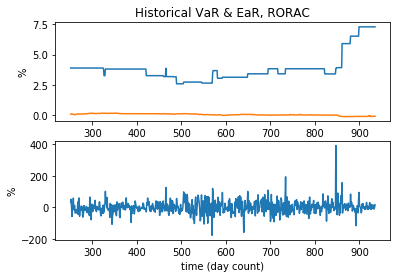

In [6]:
count.plot()

## Тест на нормальность (Shapiro-Wilk Test & Kolmogorov-Smirnov Test)

In [7]:
count.normality()

'Statistics Shapiro=0.906, p=0.000 & Statistics KS-test=0.479, p=0.000'

Логдоходности не могут быть признаны нормальными, а значит, параметрический вариант оценивания не подходит

## Результаты расчетов для Лукойла

In [8]:
paths = paths_define()
print(paths[1])
count2 = DataCounter(paths[1])
count2.solve()

/Users/nikitapostnov/Desktop/risk_management_finance/assignment_1/data/LKOH_160101_190916.csv


,Date,Hist VaR,Hist EaR,Hist RORAC,Param VaR,Param EaR,Param RORAC
251,20161230,0.038818,-0.002325,0.243545,0.035542,-0.001597,0.245498
252,20170103,0.038807,-0.002334,0.984753,0.035670,-0.001733,1.054494
253,20170104,0.038807,-0.002302,-0.638412,0.035904,-0.001507,-0.712157
254,20170105,0.038807,-0.002302,-0.695934,0.036286,-0.001394,-0.769289
255,20170106,0.038807,-0.002302,-0.047669,0.035288,-0.001583,-0.072789
256,20170109,0.038807,-0.002334,0.209043,0.035125,-0.001667,0.211970
257,20170110,0.038807,-0.002377,0.171426,0.035112,-0.001681,0.169643
258,20170111,0.038807,-0.002377,0.027124,0.034960,-0.001741,0.011908
259,20170112,0.038807,-0.002377,-0.666296,0.034594,-0.001797,-0.764190
260,20170113,0.038807,-0.002334,-0.018061,0.034633,-0.001759,-0.036848


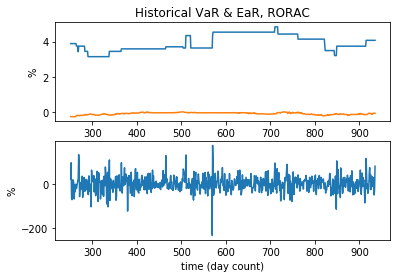

In [9]:
count2.plot()

## Тест на нормальность (Shapiro-Wilk Test & Kolmogorov-Smirnov Test)

In [10]:
count2.normality()

'Statistics Shapiro=0.975, p=0.000 & Statistics KS-test=0.479, p=0.000'

Логдоходности не могут быть признаны нормальными, а значит, параметрический вариант оценивания не подходит

# Сравнение динамики риск-показателей

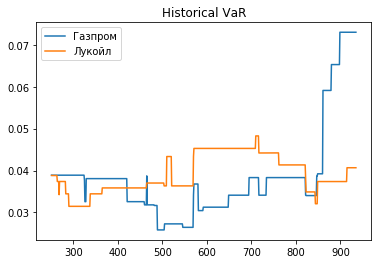

In [11]:
plt.figure()
plt.plot(list(range(len(count.date))), count.historical_var)
plt.plot(list(range(len(count.date))), count2.historical_var)
plt.legend(['Газпром', 'Лукойл'])
plt.title('Historical VaR')
plt.show()

В динамике VaR не особо заметны какие-то общие характерные паттерны. Несмотря на это, за последние 100 дней VaR Газпрома существенно взлетел, что говорит о том, что на газовую промышленность (Газпром, наверное, можно считать хорошим прокси для всей промышленности из-за занимаемой доли) давят геополитические события. Эта гипотеза связана, прежде всего, с долей государства в одной и другой компании (очевидно, Газпром как национальное достояние - чисто государственная корпорация, что не верно для Лукойла).

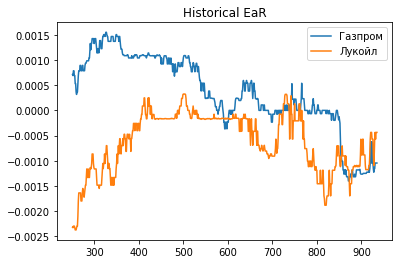

In [12]:
plt.figure()
plt.plot(list(range(len(count.date))), count.historical_ear)
plt.plot(list(range(len(count.date))), count2.historical_ear)
plt.legend(['Газпром', 'Лукойл'])
plt.title('Historical EaR')
plt.show()

В динамике EaR'а, по крайней мере, на первой половине рассматриваемого интервала времени, видны либо различные подходы к управлению портфелем (риск процентной ставки в случае Лукойла растет, а в случае Газпрома - снижается), что может быть связано с разной зависимостью компаний от международного рынка, либо различное влияние одного и того же изменения ставок на качество портфеля. 

Здесь под портфелем мы понимаем активы, генерирующие потоки платежей, и соответственно CF. 